In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Exploring Hopfield Based Models
===

This tutorial explores the different dynamics of Hopfield based models.

The Hopfield neural network is a discrete time dynamical system composed of multiple binary nodes, with a connectivity matrix built from a predetermined set of patterns. The update, inspired from the spin-glass model (used to describe magnetic properties of dilute alloys), is based on a random scanning of every node. The existence of fixed point dynamics is guaranteed by a Lyapunov function. The Hopfield network is expected to have those multiple patterns as attractors (multistable dynamical system). When the initial conditions are close to one of the 'learned' patterns, the dynamical system is expected to relax on the corresponding attractor. 

A possible output of the system is the final attractive state (interpreted as an associative memory).

Various extensions of the initial model have been proposed, among which a noiseless and continuous version [Hopfield 1984] having a slightly different Lyapunov function, but essentially the same dynamical properties, with more straightforward physiological interpretation. A continuous Hopfield neural network (with a sigmoid transfer function) can indeed be interpreted as a network of neural masses with every node corresponding to the mean field activity of a local brain region, with many bridges with the Wilson Cowan model [ref].

**References**:

[Hopfield1982] Hopfield, J. J., *Neural networks and physical systems with emergent collective computational abilities*, Proc. Nat. Acad. Sci. (USA) 79, 2554-2558, 1982.

[Hopfield1984] Hopfield, J. J., *Neurons with graded response have collective computational properties like those of two-sate neurons*, Proc. Nat. Acad. Sci. (USA) 81, 3088-3092, 1984.

See also, http://www.scholarpedia.org/article/Hopfield_network

**Note:** This model can use a global and dynamic (time-varying) threshold permitting multistable dynamic for a positive structural connectivity matrix.

## Libraries

In [2]:
from tvb.simulator.lab import *

----------
##Configuration
In the following **S/D** will refer to **Static/Dynamic** and **L/G** to **Local/Global** respectively.
Thus there are 4 variants or models

Static Local (**SL**)

Static Global (**SG**)

Dynamic Local (**DL**)

Dynamic Global (**DG**)


**Parameters**

In [3]:
# Global coupling function parameters
P_SL = 1.0       # Excitation / Inhibition ratio in sigmoidal coupling
P_SG = 0.9
P_DL = 4.0
P_DG = 0.6
G = 900.         # Gain of sigmoidal coupling

# Model parameters
taux = 10.       # Time constant for potentials
tauT = 80.       # Time constant for inhibition
sigx = 8e-5      # Noise on potentials
sigT = 3e-6      # Noise for inhibition
dt = 0.1         # Time step [ms]
f0 = 0.3         # Initial density

**Model**

In [4]:
# Initialise two different Model objects
modelS = models.Hopfield(taux=taux)
modelD = models.Hopfield(taux=taux, tauT=tauT, dynamic=1)

**Connectivity**

In [5]:
path = os.path.dirname(simulator.__file__), "files", "connectivity", "hagmann_hemisphere_both_subcortical_false_66.zip"
Connectome = connectivity.Connectivity.from_file("connectivity_66.zip")
Connectome.weights /= norm(Connectome.weights) # to have the same P parameters used for the models
Connectome.configure()                         # to reach the number of nodes

**Coupling and $\theta_{Static}$ initialization**

In [7]:
thetaL = (Connectome.weights.sum(0) * 0.5)          # As defined in Continuous Hopfield model
thetaG = [(Connectome.weights.sum(0) * 0.5).mean()] # Average over nodes for a global threshold
coupSL = coupling.PreSigmoidal(G=G, P=P_SL, dynamic=0, globalT=0, theta=thetaL)
coupSG = coupling.PreSigmoidal(G=G, P=P_SG, dynamic=0, globalT=1, theta=thetaG)
coupDL = coupling.PreSigmoidal(G=G, P=P_DL, dynamic=1, globalT=0)
coupDG = coupling.PreSigmoidal(G=G, P=P_DG, dynamic=1, globalT=1)

AttributeError: expected type <class 'tvb.basic.traits.types_basic.Bool'>, received type <type 'int'>

**Integrator & Noise**

In [8]:
noiseS  = noise.Additive(nsig = array([sigx])) 
noiseDL = noise.Additive(nsig = array([sigx, sigT]))
noiseDG = noise.Additive(nsig = array([sigx, sigT]))
integratorS = integrators.EulerStochastic(dt=dt, noise=noiseS)
integratorDL = integrators.EulerStochastic(dt=dt, noise=noiseDL)
integratorDG = integrators.EulerStochastic(dt=dt, noise=noiseDG)

**Monitors**

In [9]:
monitorsS = monitors.Raw()
monitorsD = monitors.Raw()

----------
## Initialization & Run

**Initial Conditions**

We can consider the *initial density* as the number of active nodes over the number of nodes at t=0.
The number of possible attrators for the **SL model** is the biggest for an initial density of **0.5** and P=1.
For the **SG model**, it is for an initial density of **0.3** and P=0.9. The **D models** don't need specific initial densities.

**Note:** For the **DG model**, the initialization of the threshold $\theta$ have to be a vector with a size equal to the number of nodes. Onyl the first node is used as a global node but the others have also to be initialized.

In [10]:
# This should be the history array shape ... The base Hopfield model has two state-variables.
SVshape = 1, 1, Connectome.number_of_regions, 1

x_0 = np.where(rand(*SVshape) > f0, 0., 0.5)
x_0b= np.where(rand(*SVshape) > 0.3, 0., 0.5)
theta0_L = (P_DL * Connectome.weights.dot(x_0)).reshape(SVshape)
theta0_G = (P_DG * Connectome.weights.dot(x_0).mean() * ones(Connectome.number_of_regions)).reshape(SVshape)

initialSL = concatenate([x_0, zeros(x_0.shape)], axis=1)
initialSG = concatenate([x_0b, zeros(x_0b.shape)], axis=1)
initialDL = concatenate((x_0, theta0_L), axis=1)
initialDG = concatenate((x_0, theta0_G), axis=1)

**Simulator**

In [11]:
static = {'model': modelS,
          'integrator': integratorS,
          'monitors': monitorsS,
          'connectivity': Connectome,}
dynamic = {'model': modelD,
           'monitors': monitorsD,
           'connectivity': Connectome,}

In [12]:
simSL = simulator.Simulator(coupling=coupSL, initial_conditions=initialSL, **static)
simSG = simulator.Simulator(coupling=coupSG, initial_conditions=initialSG, **static)
simDL = simulator.Simulator(coupling=coupDL, integrator=integratorDL, initial_conditions=initialDL, **dynamic)
simDG = simulator.Simulator(coupling=coupDG, integrator=integratorDG, initial_conditions=initialDG, **dynamic)
simSL.configure()
simSG.configure()
simDL.configure()
simDG.configure()

NameError: name 'coupSL' is not defined

**Static & Local**

In [13]:
raw_data_SL = []

In [14]:
for raw, in simSL(simulation_length=250):
    raw_data_SL.append(raw[1])
SL_X = array(raw_data_SL)[:,0,:,0]

NameError: name 'simSL' is not defined

**Static & Global**

In [15]:
raw_data_SG = []

In [16]:
for raw, in simSG(simulation_length=250):
    raw_data_SG.append(raw[1])
SG_X = array(raw_data_SG)[:,0,:,0]

NameError: name 'simSG' is not defined

**Dynamic & Local**

In [30]:
raw_data_DL = []

In [31]:
for raw, in simDL(simulation_length=2500):
    raw_data_DL.append(raw[1])
DL_X = array(raw_data_DL)[:,0,:,0]

**Dynamic & Global**

In [32]:
raw_data_DG = []

In [33]:
for raw, in simDG(simulation_length=5000):
    raw_data_DG.append(raw[1])
DG_X = array(raw_data_DG)[:,0,:,0]

----------
## Display

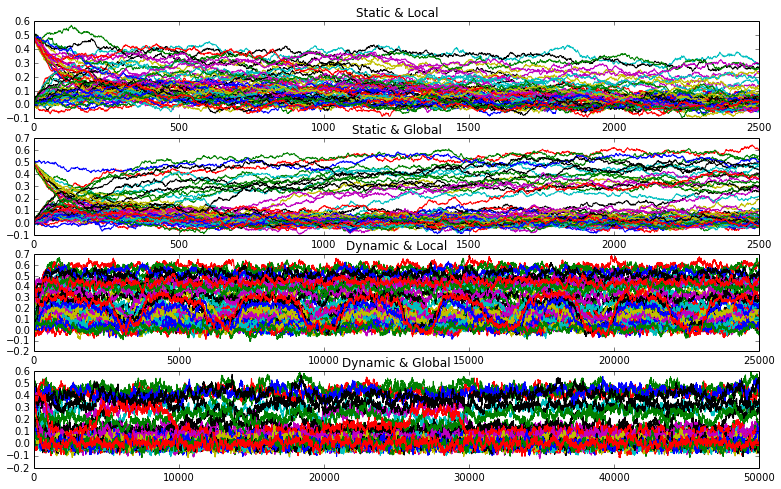

In [34]:
figure(figsize=(13,8))
subplot(411); plot(SL_X); title('Static & Local')
subplot(412); plot(SG_X); title('Static & Global')
subplot(413); plot(DL_X); title('Dynamic & Local')
subplot(414); plot(DG_X); title('Dynamic & Global'); show()

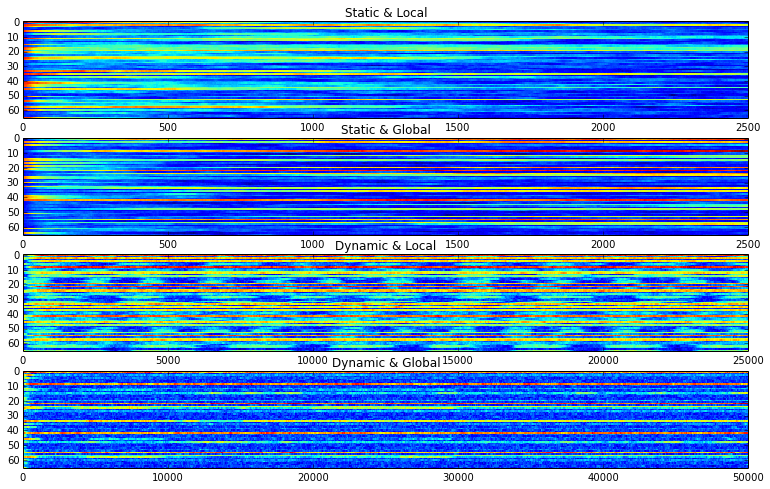

In [35]:
figure(figsize=(13,8))
subplot(411); imshow(SL_X.T, aspect='auto', interpolation='nearest'); title('Static & Local')
subplot(412); imshow(SG_X.T, aspect='auto', interpolation='nearest'); title('Static & Global')
subplot(413); imshow(DL_X.T, aspect='auto', interpolation='nearest'); title('Dynamic & Local')
subplot(414); imshow(DG_X.T, aspect='auto', interpolation='nearest'); title('Dynamic & Global'); show()